In [1]:
import numpy as np
import pandas as pd
import sklearn.svm as svm
import sklearn.cluster as cl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
from typing import Dict
import random

In [2]:
from enum import Enum 

#class responsible for comparing clusters
class Comparator(Enum):
    SMALLER = -1
    EQUAL = 0
    LARGER = 1

In [4]:
# read in files
def load_dataset(file: str) -> Dict:
    
    items = ["RawData",
             "IAV-M_NEG_RawData",
             "IAV-M_POS_RawData",
             "IBV-M_NEG_RawData",
             "IBV-M_POS_RawData",
             "MHV_NEG_RawData",
             "MHV_POS_RawData",
             "RSV-N_NEG_RawData",
             "RSV-N_POS_RawData",
             "SARS-N1_NEG_RawData",
             "SARS-N1_POS_RawData",
             "SARS-N2_NEG_RawData",
             "SARS-N2_POS_RawData",
            ]
    path_map = {}
    df_all_map = {}
    for name in items:
        path_map[name] = file + f'{name}.csv'
        df_all_map[name] = pd.read_csv(path_map[name])

    return df_all_map


In [5]:
def get_coloring(n_labels : int) -> np.array:
    colors = cm.rainbow(np.linspace(0, 1, n_labels + 1))
    colors[-1, :] = np.array([0.0, 0.0, 0.0, 1.0])
    return colors

In [6]:
#Using Gernots plot to get the overview of the data and the clusters
def pairwise_plots_dbscan(df, eps, min_samples = 5):
    np_features = df.drop(["x-coordinate_in_pixel"," y-coordinate_in_pixel"," index"], axis=1)
    np_features = np_features.to_numpy()
    classifier = cl.DBSCAN(eps = eps, min_samples = min_samples)
    preds = classifier.fit_predict(np_features)

    
    print(f"Number of outliers: {len([x for x in preds if x == -1])}") # print number of outliers
    print(f"Number of clusters: {max(preds)+1}") # print number of clusters

    # setting the colors
    colors = get_coloring(max(preds) + 1)
    
    combinations = itertools.combinations(df.columns[2:-1], 2)
    fig, ax = plt.subplots(5, 3, sharex=False, sharey=False)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i, combination in enumerate(combinations): 
        np_features = df.loc[:, combination]
        np_features = np_features.to_numpy()

        ax[i //3, i %3].set_xlabel(combination[0])
        ax[i //3, i %3].set_ylabel(combination[1])
        ax[i //3, i %3].scatter(np_features[:, 0], np_features[:, 1], c = colors[preds])
    fig.tight_layout()

## A3 data set ##
Identifying clusters on the **A3 data set**

Number of outliers: 23
Number of clusters: 5


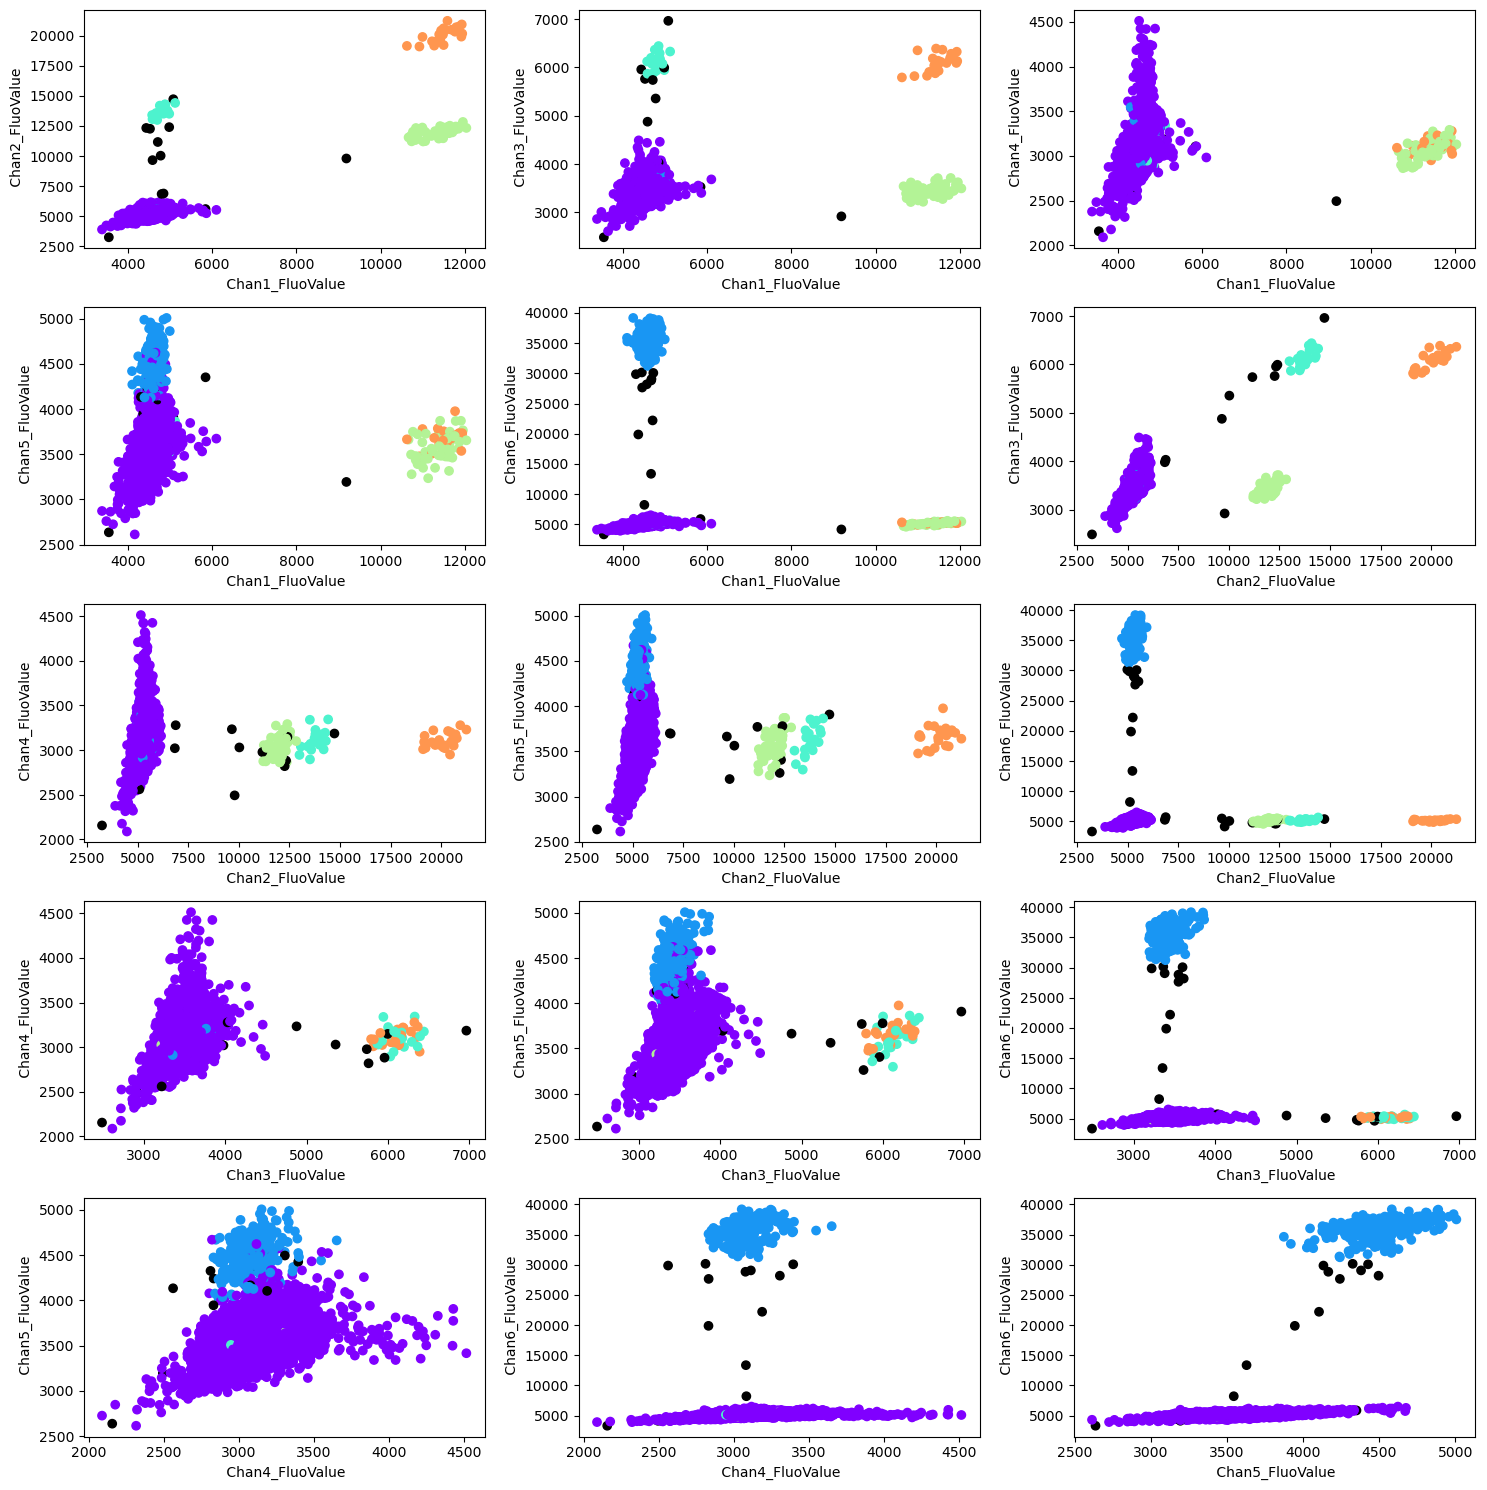

In [7]:
file = "../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData/6P-wastewater-samples-labelled_S-0697825-9_A3_"
df = load_dataset(file)["RawData"]
pairwise_plots_dbscan(df, eps = 700, min_samples = 5)

## D3 data set ##
Identifying clusters on the **D3 data set**

Number of outliers: 229
Number of clusters: 25


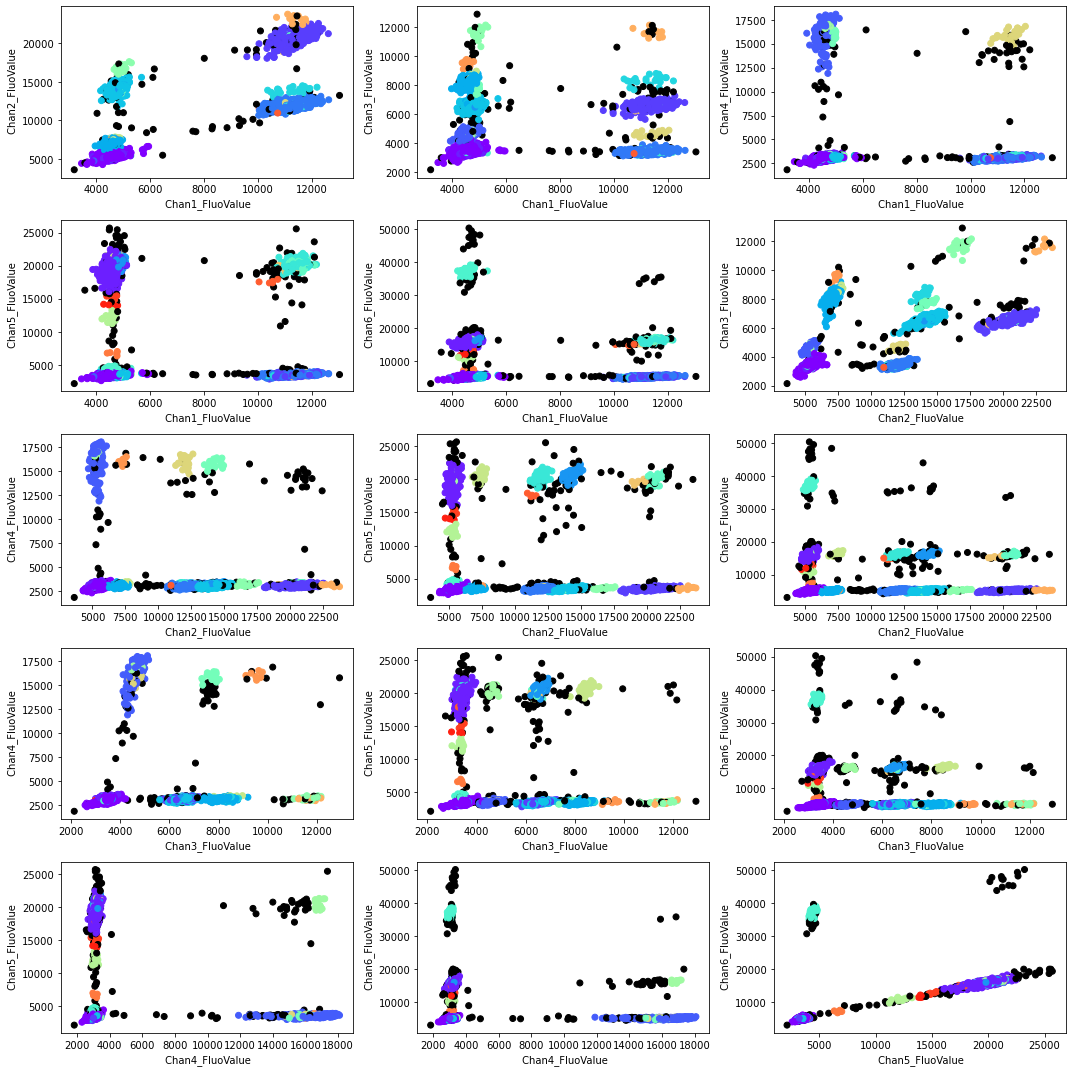

In [59]:
file2 = "../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData/6P-wastewater-samples-labelled_S-0697825-9_C3_"
df2 = load_dataset(file2)["RawData"]
pairwise_plots_dbscan(df2, eps = 700, min_samples = 5)

## Computing midpoints for all clusters ##
The **midpoint_clusters** function computes the midpoint for each of the clusters, where data is a (num_points x dim) ndarray


In [60]:
def compute_midpoints(data : np.ndarray, labels : np.ndarray, n_clusters : int) -> np.ndarray:

    # number of data points in total (number of rows)
    N = data.shape[0]

    # dimensionality of data (number of columns)
    dim = data.shape[1]
    
    # computing the size and norm of each cluster
    cluster_norm = np.zeros((n_clusters, dim), float)
    cluster_size = np.zeros(n_clusters, int)
    
    for i in range(0, N):
        if labels[i] >= 0:
            cluster_size[labels[i]] += 1
            cluster_norm[labels[i], :] += data[i, :]
        
    # computing the average point for all the clusters
    for i in range(n_clusters):
        cluster_norm[i, :] = cluster_norm[i, :] / cluster_size[i]
    
    return cluster_norm
        

## Splitting data in clusters according to their labels ##
Reshapes the data (N x dim) array to a list of array such that every element correspond to a different cluster

In [61]:
def split_clusters(data: np.ndarray, labels : np.ndarray, n_clusters : int) -> list[np.ndarray]:
    temp = [[] for _ in range(n_clusters)]

    # number of data points in total (number of rows)
    N = data.shape[0]

    # dimensionality of data (number of columns)
    dim = data.shape[1]

    for i in range(0, N):
        if labels[i] >= 0:
            temp[labels[i]].append(data[i, :])
        
    return [np.array(elem) for elem in temp]

## Deciding whether two clusters are the same with respect to some feature ##
If the midpoint of one cluster can be perfectly separated from a different cluster and the distance is sufficiently large then we call two cluster distinct with respect to a feature. In general we use the **zero_cluster** as _base_cluster_ and your cluster as _other_cluster_, however due to correlation one will also need to compare different clusters.

In [67]:
#returns feature coordinates mapped to the Comparator class based on which coordinates are different
def compare_clusters(base_cluster : np.ndarray, other_cluster : np.ndarray, base_mid : np.ndarray, other_mid : np.ndarray, eps = 1.7 ) -> list[Comparator]:
    
    # number of features
    dim = base_cluster.shape[1]
    assert dim == other_cluster.shape[1], "Number of features inconsistent!"

    # number of points in each cluster
    N1 = base_cluster.shape[0]
    N2 = other_cluster.shape[0]

    # list of comparasings
    list = [Comparator.EQUAL]*dim

    # we are simply performing the comparison of the midpoints to determine whther the clusters are different
    # this should be replaced with a more complex algortihm in the future 
    
    for i in range(0, dim):
        if (base_mid[i] / other_mid[i] > eps):
            list[i] = Comparator.SMALLER
        elif (other_mid[i] / base_mid[i] > eps):
            list[i] = Comparator.LARGER
        else:
            list[i] = Comparator.EQUAL
            # here one can do more sophisticated testing
    
    return list
        

### Creating equivalence classes for clusters among the feature lists ##
Idea: we call a cluster active in at least $k+1$ axis if and only if there exists a different cluster which is active in $k$* axis and our cluster is at least is active as this cluster in every dimension, and strictly more active in at least one dimension. *Notice, this is an inductive definition*

*Note: this code should be optimized later on. We don't have to compare the same clusters multiple times (in our case 6 times)*

In [63]:
def compute_hierarchy(cluster_list : list[np.ndarray], midpoints : np.ndarray, n_clusters : int, dim : int) -> np.ndarray:
    
    # consider all pairs of clusters
    pairs = list(itertools.combinations(range(n_clusters), 2))
    hierarchy = np.zeros(n_clusters, int)

    # we define rank ot refer to the number of active features
    for rank in range(dim+1):
        for (base, other) in pairs:
            # we only consider clusters of given rank
            if hierarchy[base] < rank or hierarchy[other] < rank:
               continue
            
            temp = compare_clusters(cluster_list[base], cluster_list[other], midpoints[base, :], midpoints[other, :]);

            # decide whether the other_cluster is stirctly more active then base
            other_superior : bool = False
            base_superior : bool = False

            # more active = more active in one coordinate
            if (Comparator.LARGER in temp) and (Comparator.SMALLER not in temp):
                other_superior = True

            # more active = at least as active in other coordinates
            if (Comparator.LARGER not in temp) and (Comparator.SMALLER in temp):
                base_superior = True

            # other is hence active in at least =rank coordinates, hece deserves a higher rank
            if other_superior:
                hierarchy[other] = rank + 1;

            if base_superior:
                hierarchy[base] = rank + 1;

    return hierarchy
    


## Labelling clusters with respect to the control cluster ##
The **get_labelling** function compares a cluster with a zero cluster along each axis and selects the coordinates in which it is active. This is a more complicated alternative to the midpoint method we are using right now.

In [64]:
def get_labelling(zero_cluster : np.ndarray, my_cluster : np.ndarray) -> list[Comparator]:
    dim = my_cluster.shape[1]
    zero_size = zero_cluster.shape[0]
    other_size = my_cluster.shape[0]
    active = []
    for i in range(dim):
        #set up the classification framework
        X = np.concatenate((zero_cluster, my_cluster))
        
        #true labels are both of our clusters concatenated
        true_labels = np.array([0]*zero_size + [1]*other_size)
        
        #run 1D svm
        clf = svm.SVC(kernel='linear', C=1.0)
        clf.fit(X, true_labels)
        
        #test how good the fit was
        score = clf.score(X, true_labels)
        #if SVM was good at separating our clusters then one of them is active in the coordinate
        if score < 1:
            active.append(1)
        else:
            active.append(0)
    return active

# Testing on the A3 data set #

## [T1] cluster_hierarchy function ##
Testing the performance of the **cluster_hierarchy** function on the A3 dataset. We assign colours based on the number of active coordinates in the cluster. The lighter the color the more coordinates are active.

Hierarchy:  [0 1 1 1 2]


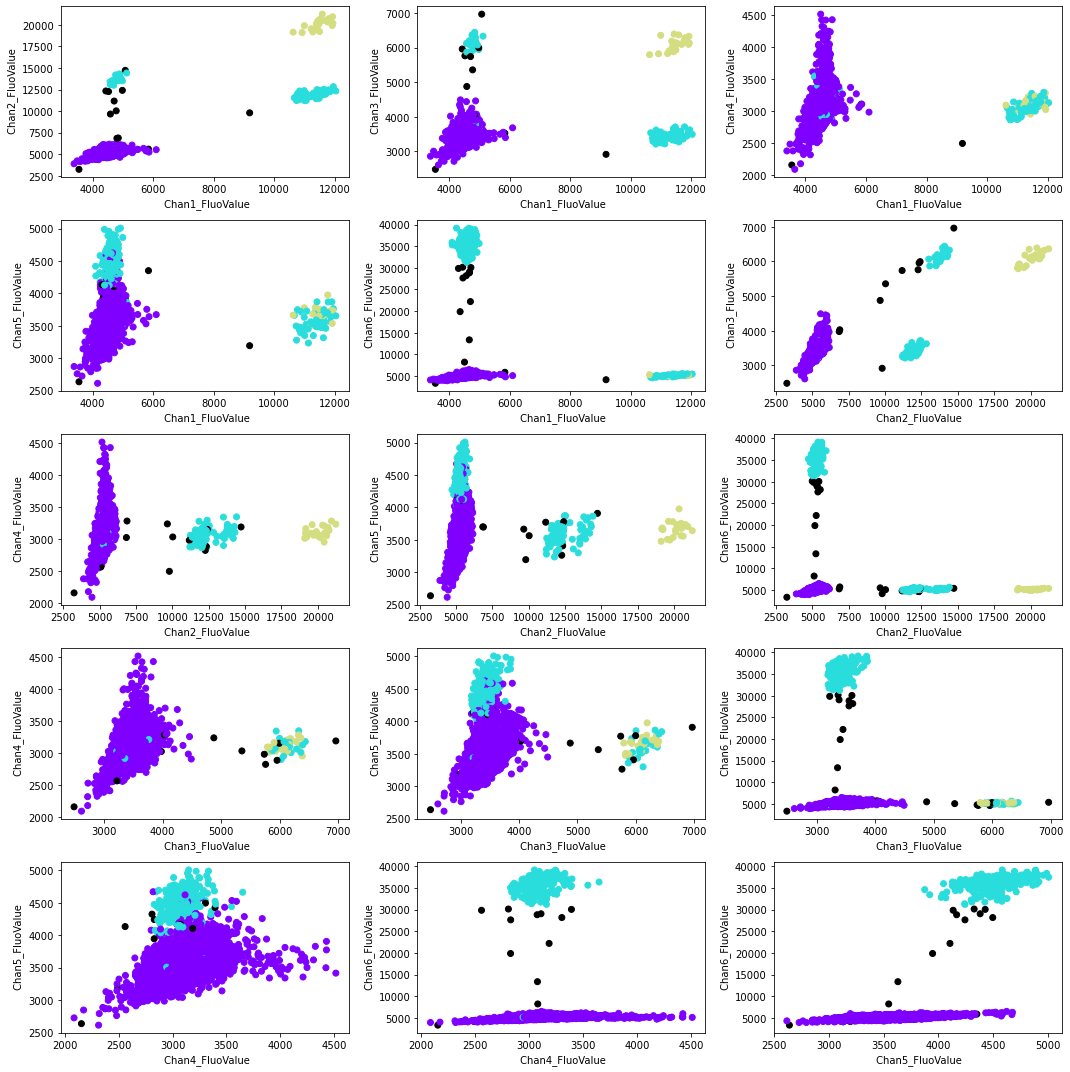

In [68]:
# initial initialization
data = df.drop(["x-coordinate_in_pixel"," y-coordinate_in_pixel"," index"], axis=1)
data = data.to_numpy()
classifier = cl.DBSCAN(eps = 700, min_samples = 5)
labels = classifier.fit_predict(data)

# computing the hierarchy using the subroutines
N = data.shape[0]
n_clusters = max(labels) + 1
dim = data.shape[1]

clusters = split_clusters(data, labels, n_clusters)
midpoints = compute_midpoints(data, labels, n_clusters)

hierarchy = compute_hierarchy(clusters, midpoints, n_clusters, dim)

print("Hierarchy: ", hierarchy)

# convert the labelling to individual points
point_hierarchy = np.full(N, -1)
for i in range(N):
    if labels[i] >= 0:
        point_hierarchy[i] = hierarchy[labels[i]]

# setting the colors
colors = get_coloring(max(hierarchy) + 1)

# using Gernots plotting code
combinations = itertools.combinations(df.columns[2:-1], 2)
fig, ax = plt.subplots(5, 3, sharex=False, sharey=False)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, combination in enumerate(combinations): 
    np_features = df.loc[:, combination]
    np_features = np_features.to_numpy()

    ax[i //3, i %3].set_xlabel(combination[0])
    ax[i //3, i %3].set_ylabel(combination[1])
    ax[i //3, i %3].scatter(np_features[:, 0], np_features[:, 1], c = colors[point_hierarchy])
fig.tight_layout()

# Testing on the D3 data set #

## [T1] cluster_hierarchy function ##
Testing the performance of the **cluster_hierarchy** function on the D3 dataset. We assign colours based on the number of active coordinates in the cluster.

Hierarchy:  [0 2 3 1 1 4 1 2 4 3 2 5 4 3 3 2 3 5 5 4 2 1 3 2 2]


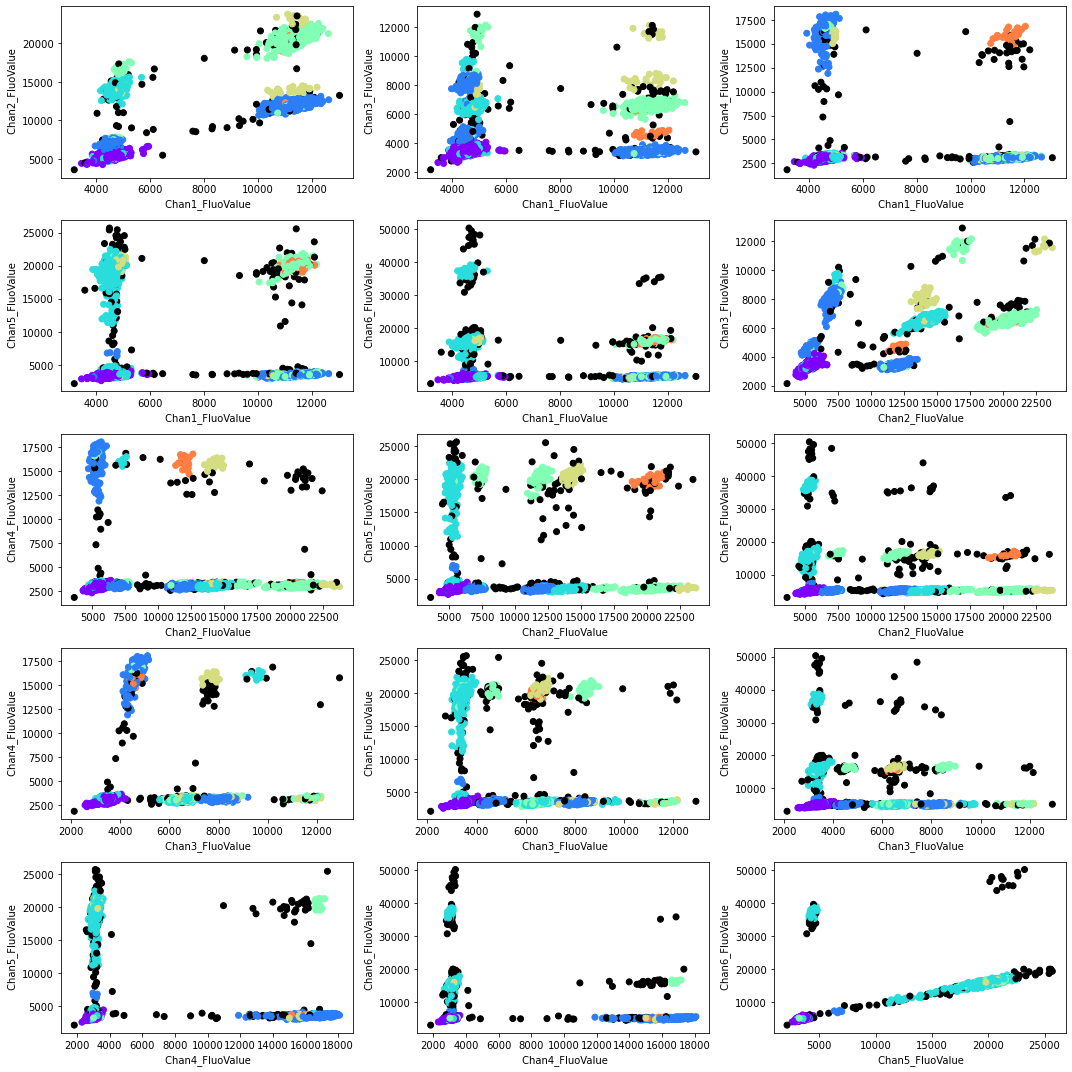

In [69]:

# initial initialization
data2 = df2.drop(["x-coordinate_in_pixel"," y-coordinate_in_pixel"," index"], axis=1)
data2 = data2.to_numpy()

labels = classifier.fit_predict(data2)

# computing the hierarchy using the subroutines
N = data2.shape[0]
n_clusters = max(labels) + 1
dim = data2.shape[1]

clusters = split_clusters(data2, labels, n_clusters)
midpoints = compute_midpoints(data2, labels, n_clusters)

hierarchy = compute_hierarchy(clusters, midpoints, n_clusters, dim)

print("Hierarchy: ", hierarchy)

# convert the labelling to individual points
point_hierarchy = np.full(N, -1)
for i in range(N):
    if labels[i] >= 0:
        point_hierarchy[i] = hierarchy[labels[i]]

# setting the colors
colors = get_coloring(max(hierarchy) + 1)
    
# using Gernots plotting code
combinations = itertools.combinations(df.columns[2:-1], 2)
fig, ax = plt.subplots(5, 3, sharex=False, sharey=False)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, combination in enumerate(combinations): 
    np_features = df2.loc[:, combination]
    np_features = np_features.to_numpy()

    ax[i //3, i %3].set_xlabel(combination[0])
    ax[i //3, i %3].set_ylabel(combination[1])
    ax[i //3, i %3].scatter(np_features[:, 0], np_features[:, 1], c = colors[point_hierarchy])
fig.tight_layout()



## get_labelling function ##

*not optimally implemented yet*

In [ ]:
def get_labelling(zero_cluster : np.ndarray, my_cluster : np.ndarray) -> list[bool]:
    dim = my_cluster.shape[1]
    zero_size = zero_cluster.shape[0]
    other_size = my_cluster.shape[0]
    active = []
    for i in range(0, dim):
        #set up the classification framework
        X = np.concatenate((zero_cluster, my_cluster))
        
        #true labels are both of our clusters concatenated
        true_labels = np.array([0]*zero_size + [1]*other_size)
        
        #run 1D svm
        clf = svm.SVC(kernel='linear', C=1.0)
        clf.fit(X, true_labels)
        
        #test how good the fit was
        score = clf.score(X, true_labels)
        #if SVM was good at separating our clusters then one of them is active in the coordinate
        if score < 1:
            active.append(1)
        else:
            active.append(0)
    return active

## TODO ## 
Different separation threshold for different axis